In [3]:
#!/usr/bin/env python3

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import quad
from scipy.special import hermite
from scipy.optimize import curve_fit
from scipy.fft import fft, fftfreq

In [2]:
#column_names = ['velocity'] #In this case is necesary define the name of the column

In [3]:

df = pd.read_csv('ACE_merge64s.dat',delim_whitespace=True, header=0)

#print(df)

dt = 74
time =  pd.Series([i*dt for i in range(len(df))])
range_1= (df['V'] >= 0) & (df['V'] <= 9000)

df['time'] = time

std_total= df['V'].std()

#print(df)

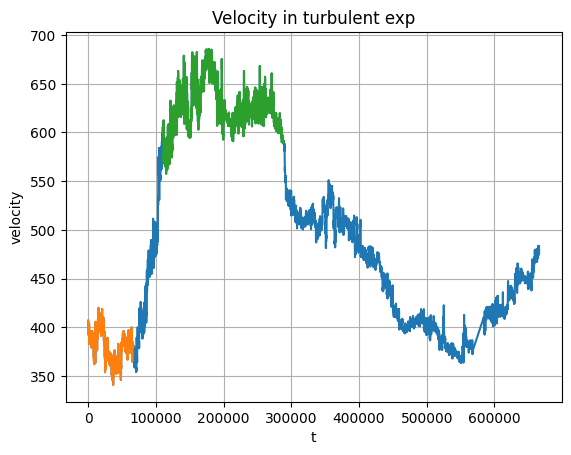

In [4]:
###  PLOT TIME SERIES  #######
plt.plot(df['time'].iloc[0:9000], df['V'].iloc[0:9000])
plt.plot(df['time'].iloc[0:900], df['V'].iloc[0:900])
plt.plot(df['time'].iloc[1500:3900], df['V'].iloc[1500:3900])
plt.xlabel('t')
plt.ylabel('velocity')
plt.title('Velocity in turbulent exp')
plt.grid(True)
plt.show()


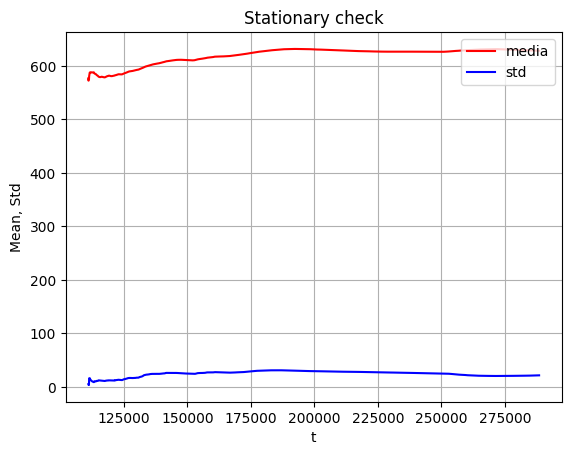

In [11]:
### STATIONARITY CHECK ###################

size_window = len(df) // 5

#df_filtred['V']=df['V'].iloc[1500:3900]
# Calcular la media y la desviación estándar en cada ventana móvil
mean_window = df['V'].iloc[1500:3900].rolling(window=size_window, min_periods=1,step=1).mean()
desviation_window = df['V'].iloc[1df['V'].iloc[1500:3900]500:3900].rolling(window=size_window, min_periods=1,step=1).std()

# Agregar las medias y desviaciones estándar al DataFrame original
df['mean_window'] = mean_window
df['desviation_window'] = desviation_window



 ###GRAFICO SERIE DE TIEMPO DE VELOCIDAD#######
plt.plot(df['time'], df['mean_window'],label='media',color='red')
plt.plot(df['time'], df['desviation_window'],label='std',color='blue')
plt.xlabel('t')
plt.ylabel('Mean, Std')
plt.title('Stationary check')
plt.legend(loc = 'upper right')
plt.grid(True)
plt.show()
 ##########################################
### STATIONARITY CHECK END ###################

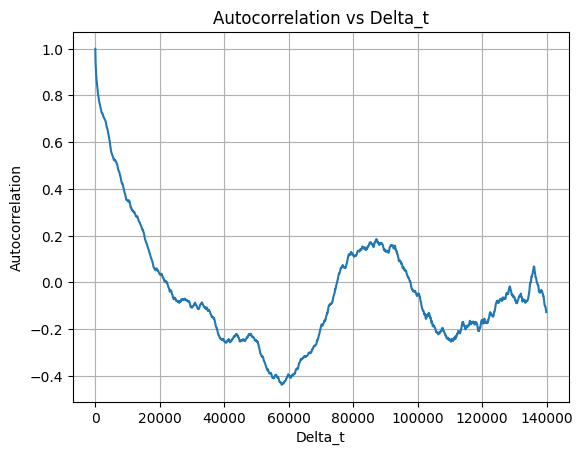

In [14]:
###### AUTOCORRELATION ###########
size_window = len(df) // 5 ##### regulrizar normalizacin y tamaño de la ventana al iloc que estoy obervando // cuando no 

delta_t_values = [n * dt for n in range(0, size_window + 1, 1)]

#### RENORMLAIZACIÓN DE VENTANAS ####

std_window=df['V'].iloc[1500:3900].std()
#df_normalized=df['V'].iloc[1500:3900]/


autocorelations = []
# normalizacion
#########TRASLADAR TODA LA FUNCION AL CERO 
#print(std_total)

# Calcular la función de autocorrelación para diferentes valores de Delta t

for delta_t in delta_t_values:
   # Desplazar la serie de velocidad en Delta t
    velocity_shifted = df['V'].iloc[1500:3900].shift(-int(delta_t / dt))
    
  #  Calcular el producto punto entre la serie de velocidad original y la desplazada
    product = (df['V'].iloc[1500:3900]-df['V'].iloc[1500:3900].mean()) * (velocity_shifted-df['V'].iloc[1500:3900].mean())
    
    # Calcular la media sobre todo el tiempo t
    autocorrelation = product.mean()/(std_window**2)
    autocorelations.append(autocorrelation)


autocorrelations_df = pd.DataFrame({'Delta_t': delta_t_values, 'Autocorrelation': autocorelations})

# Mostrar el DataFrame de autocorrelaciones
#print(autocorrelaciones_df)

# Graficar la autocorrelación versus el intervalo de tiempo Delta_t
plt.plot(autocorrelations_df['Delta_t'], autocorrelations_df['Autocorrelation'])
plt.xlabel('Delta_t')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation vs Delta_t')
plt.grid(True)
plt.show()

###### AUTOCORRELATION END ###########


In [13]:
######### AUTOCORRELATION SCALE ##########

# Supongamos que autocorrelations_df contiene los datos con las autocorrelaciones y delta_t_values contiene los valores de Delta t correspondientes
autocorrelation_scale_total = np.trapz(autocorrelations_df['Autocorrelation'], x=autocorrelations_df['Delta_t'])
print(autocorrelation_scale_total)
# Encontrar el primer cruce por cero en las autocorrelaciones
zero_cross = autocorrelations_df[autocorrelations_df['Autocorrelation'] < 0].index.min()
print(zero_cross,zero_cross*dt)
# Si hay cruce por cero, limitar el DataFrame de autocorrelaciones hasta ese punto
if zero_cross is not None:
    autocorrelations_df_wz = autocorrelations_df.iloc[:zero_cross + 1]
    

# Calcular la integral numérica utilizando la regla del trapecio
autocorrelation_scale = np.trapz(autocorrelations_df_wz['Autocorrelation'], x=autocorrelations_df_wz['Delta_t'])

print("autocorrelation scale:", autocorrelation_scale)


-405.79364295039824
297 21978
autocorrelation scale: 494.07836243778974


In [8]:
####### POWER LAW ########

from scipy.optimize import curve_fit

# Extraer la serie de velocidad
velocity = df['velocity'].values

# Calcular la Transformada Rápida de Fourier (FFT) de la velocidad
fft_velocity = fft(velocity)
fft_velocity_square= np.abs(fft_velocity)**2
fft_velocity_square_positive= fft_velocity_square[:len(fft_velocity_square)//2]
# Calcular la frecuencia correspondiente a cada punto en la FFT
frecuency = fftfreq(len(velocity), d=dt)
positive_frecuency=frecuency[:len(frecuency)//2]
frecuency_time_scale=1/autocorrelation_scale


######## PRUEBA WAVELETS ##############
import pywt

# Aplicar la transformada wavelet a los datos de la FFT
coeffs = pywt.wavedec(fft_velocity_square_positive, 'db1', level=3)

# Eliminar los coeficientes de alta frecuencia (umbralización)
threshold = 10**16 # Ajustar este valor según sea necesario
coeffs[1:] = (pywt.threshold(c, threshold, mode='soft') for c in coeffs[1:])

# Reconstruir la señal filtrada
filtered_fft_velocity = pywt.waverec(coeffs, 'db1')
print(filtered_fft_velocity)


# Tramar la señal filtrada
#plt.loglog(filtered_fft_velocity)
#plt.xlabel('Índice')
#plt.ylabel('Magnitud al Cuadrado de FFT Filtrada')
#plt.title('FFT Filtrada utilizando Wavelets')
#plt.grid(True)
#plt.show()


###############################

####################### AJUSTE POWER LAW ##########################
# Define la función de la ley de potencias
def power_law(x,a,b):
    return  a*x**b

# Definir el rango de frecuencia en el que deseas ajustar la ley de potencias
# Por ejemplo, si deseas ajustar en el rango de frecuencia entre 10 y 100 Hz:
f_min = 600
f_max = 2*10**3
mask = (positive_frecuency >= f_min) & (positive_frecuency <= f_max)

# Realizar el ajuste de curva utilizando curve_fit
popt, pcov = curve_fit(power_law, positive_frecuency[mask],filtered_fft_velocity[mask])


#popt, pcov = curve_fit(power_law, positive_frecuency[mask], fft_velocity_square_positive[mask])

# Parámetros óptimos del ajuste
a_opt, b_opt = popt
print("Parámetros del ajuste:")

print("b =", a_opt, b_opt)

############################## 
plt.loglog(positive_frecuency,filtered_fft_velocity)
plt.loglog(positive_frecuency[mask], power_law(positive_frecuency[mask],a_opt, b_opt), 'r', label='Ajuste de ley de potencias')

plt.xlabel('Índice')
plt.ylabel('Magnitud al Cuadrado de FFT Filtrada')
plt.title('FFT Filtrada utilizando Wavelets')
plt.grid(True)
plt.show()



#plt.loglog(positive_frecuency, fft_velocity_square_positive)
#plt.loglog(positive_frecuency[mask], power_law(positive_frecuency[mask], a_opt ,b_opt), 'r', label='Ajuste de ley de potencias')

#plt.axvline(x=frecuency_time_scale, color='r', linestyle='--')
#plt.xlabel('Frecuencia')
#plt.ylabel('Magnitud al Cuadrado de FFT')
#plt.title('Transformada de Fourier al Cuadrado vs Frecuencia')
#plt.grid(True)
#plt.show()

KeyError: 'velocity'

Parámetros del ajuste:
a,b = 65311753.97624066 -1.8592105400718892


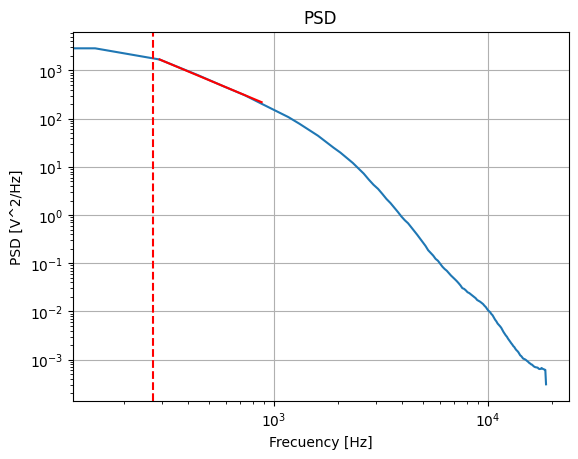

In [ ]:
from scipy.signal import welch


# Calcular la densidad espectral de potencia (PSD) utilizando el método de Welch
frequencies, psd = welch(velocity, fs=1/dt)
def power_law(x, a, b):
    return  a*x**b

# Definir el rango de frecuencia en el que deseas ajustar la ley de potencias
# Por ejemplo, si deseas ajustar en el rango de frecuencia entre 10 y 100 Hz:
f_min = frecuency_time_scale
f_max = 1000
mask = (frequencies >= f_min) & (frequencies <= f_max)

# Realizar el ajuste de curva utilizando curve_fit
popt, pcov = curve_fit(power_law, frequencies[mask], psd[mask])

# Parámetros óptimos del ajuste
a_opt, b_opt = popt
print("Parámetros del ajuste:")

print("a,b =", a_opt, b_opt)

# Plotear el espectro de frecuencia
plt.loglog(frequencies, psd)
plt.loglog(frequencies[mask], power_law(frequencies[mask], a_opt,b_opt), 'r', label='Ajuste de ley de potencias')

plt.axvline(x=frecuency_time_scale, color='r', linestyle='--')
plt.xlabel('Frecuency [Hz]')
plt.ylabel('PSD [V^2/Hz]')
plt.title('PSD')
plt.grid(True)
plt.show()

In [ ]:
###### INCREMENT ###########
import seaborn as sns
#size_window = len(df) // 10
#delta_t_values = [(2**n) * dt for n in range(0, size_window + 1, 5)]
time =  pd.Series([i*dt for i in range(len(df))])
increments_df = pd.DataFrame({ 'Increment': increments})

n= 4
delta_t_values=(2**n) * dt 

# normalizacion
#########TRASLADAR TODA LA FUNCION AL CERO 
#print(std_total)

# Calcular la función de autocorrelación para diferentes valores de Delta t

#for delta_t in delta_t_values:
   # Desplazar la serie de velocidad en Delta t
velocity_shifted = df['velocity'].shift(-int(delta_t / dt))
    
  #  Calcular el producto punto entre la serie de velocidad original y la desplazada
diff =  velocity_shifted - df['velocity']
std_diff=diff.std()
    
    # Calcular la media sobre todo el tiempo t
increment = diff/std_diff




print(time,len(time),len(increments), increments_df.shape())

# Mostrar el DataFrame de autocorrelaciones
#print(autocorrelaciones_df)

# Graficar la autocorrelación versus el intervalo de tiempo Delta_t
#plt.plot(df['time'], increments_df['Increment'])
#plt.xlabel('Delta_t')
#plt.ylabel('Autocorrelation')
#plt.title('Autocorrelation vs Delta_t')
#plt.grid(True)
#plt.show()

#sns.histplot(data=increments_df, x='Increment', bins=5, kde=True)
#plt.xlabel('Incremento')
#plt.ylabel('Frecuencia')
#plt.title('Distribución de Probabilidad de Incrementos vs Tiempo')
#plt.grid(True)
#plt.show()

###### AUTOCORRELATION END ###########

[0        -0.203718
1        -0.105442
2         0.113632
3         0.331682
4         0.464765
            ...   
442363         NaN
442364         NaN
442365         NaN
442366         NaN
442367         NaN
Name: velocity, Length: 442368, dtype: float64]


TypeError: 'tuple' object is not callable

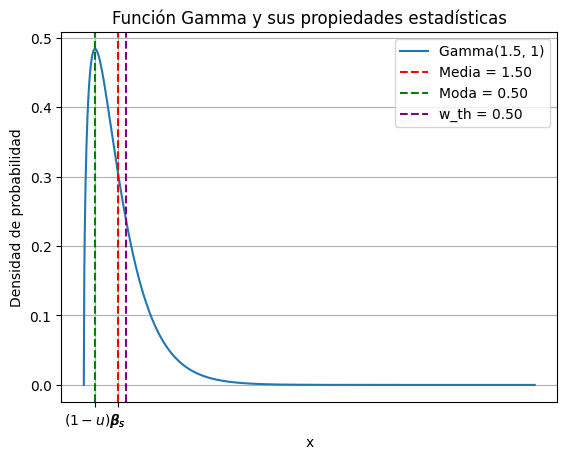

In [127]:
#!/usr/bin/env python3

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma

def gamma_stats(shape, scale):
    mean = shape * scale
    mode = (shape - 1) * scale if shape > 1 else 0
    return mean, mode

def plot_gamma(shape, scale):
    x = np.linspace(0, 20, 1000)
    y = gamma.pdf(x, shape, scale=scale)
    mean, mode = gamma_stats(shape, scale)
    
    plt.plot(x, y, label=f'Gamma({shape}, {scale})')
    plt.axvline(mean, color='r', linestyle='--', label=f'Media = {mean:.2f}')
    plt.axvline(mode, color='g', linestyle='--', label=f'Moda = {mode:.2f}')
    plt.axvline(mean+0.5*mean*mode, color='purple', linestyle='--', label=f'w_th = {mode:.2f}')

    plt.xlabel('x')
    plt.xticks(ticks=[mean, mode], labels=[r'$\beta_s$', r'$(1-u)\beta_s$'])
    #np.log(mean)
    #plt.yticks(' ')
    plt.ylabel('Densidad de probabilidad')
    plt.title('Función Gamma y sus propiedades estadísticas')
    plt.legend()
    plt.grid()
   # plt.show()
    plt.savefig('gamma_distribution.pdf')

# Parámetros de forma y escala para la función gamma
shape = 1.5
scale = 1



plot_gamma(shape, scale)